Import delle librerie.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   
torch.backends.cudnn.benchmark=True

Valorizzazione dei parametri della soluzione di FedLearning

In [3]:
num_clients = 20
num_selected = 6
num_rounds = 150
epochs = 5
batch_size = 32

 Caricamento e suddivisione del dataset CIFAR 10 tra i client. Il set di dati CIFAR10 consiste di 60.000 immagini a colori di 32x32 pixel in 10 classi. Ci sono 50.000 immagini di allenamento e 10.000 immagini di prova. Nel batch di formazione, ci sono 5.000 immagini per ogni classe, per un totale di 50.000. In PyTorch, CIFAR 10 è disponibile per l'uso con l'aiuto del modulo torchvision.

In [4]:
# Image augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=True,
                       transform= transform_train)

# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
        ), batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Costruzione della rete neurale, usando VGG19 (16 convolution layers, 3 Fully Connected layers, 5 MaxPool layers, and 1 SoftMax layer) 


In [5]:
#################################
##### Neural Network model #####
#################################

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

import torch
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, vgg_name):
      super(VGG, self).__init__()
      self.features = self._make_layers(cfg[vgg_name])
      self.classifier = nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 10)
      )      

    def forward(self, x):
      out = self.features(x)
      out = out.view(out.size(0), -1)
      out = self.classifier(out)
      output = F.log_softmax(out, dim=1)
      return output

    def _make_layers(self, cfg):
      layers = []
      in_channels = 3
      for x in cfg:
        if x == 'M':
          layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
          layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                     nn.BatchNorm2d(x),
                     nn.ReLU(inplace=True)]
          in_channels = x
      layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
      return nn.Sequential(*layers)

La funzione client_update addestra il modello client sui dati del client privato.



In [6]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

La funzione server_aggregate aggrega i pesi del modello ricevuti da ogni client e aggiorna il modello globale con i pesi aggiornati.

In [7]:
def server_aggregate(global_model, client_models):
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
      global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
      model.load_state_dict(global_model.state_dict())

La funzione di test è la funzione standard, che prende il modello globale insieme al caricatore di test come input e restituisce la perdita e l'accuratezza del test.



In [ ]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

Un modello globale, insieme ai singoli client_models, viene inizializzato con VGG19 su una GPU. SGD viene utilizzato come ottimizzatore per tutti i modelli client.

Verifica se GPU è in esecuzione. (altrimenti Go to Menu > Runtime > Change runtime.)

In [ ]:
!nvidia-smi

Sat Jul 24 07:12:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Controlla se PyTorch è in grado di utilizzare la GPU

In [8]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.


True

In [9]:
global_model =  VGG('VGG19').cuda()

############## client models ##############
client_models = [ VGG('VGG19').cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

Main dell'esempio

In [ ]:
###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []

# Runnining FL
acc_rounds = np.empty(0)
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
      loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))
    acc_rounds = np.append(acc_rounds, 100.*acc)

Realizzazione della stessa operazione di classificazione con modello centralizzato, senza Federated Learning

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

trainloader_central = torch.utils.data.DataLoader(traindata, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader_central = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model_central =  VGG('VGG19').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_central.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Training
def train(epoch):
    model_central.train()
    train_loss = 0
    correct = 0
    total = 0
    out = display(progress(0, 100), display_id=True)
    for batch_idx, (inputs, targets) in enumerate(trainloader_central):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model_central(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1)), 100.*correct/total, correct, total))
        out.update(progress(batch_idx+1, 100))
    return train_loss, correct, total

def test(epoch):
    global best_acc
    model_central.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        out = display(progress(0, 100), display_id=True)
        for batch_idx, (inputs, targets) in enumerate(testloader_central):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model_central(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #            % (test_loss/(batch_idx+1)), 100.*correct/total, correct, total))
            out.update(progress(batch_idx+1, 100))
    return test_loss, correct, total

acc_epoch = np.empty(0)
for epoch in range(start_epoch, start_epoch+150):
    train_loss, correct, total = train(epoch)
    print("Epoch %s -  Train Loss: %s | Acc: %s" %(epoch, train_loss, 100.*correct/total))
    test_loss, correct, total = test(epoch)
    print("Epoch %s -  Test Loss: %s | Acc: %s" %(epoch, test_loss, 100.*correct/total))
    acc_epoch = np.append(acc_epoch, 100.*correct/total)
    scheduler.step()

Grafico della differenza nell'accuratezza tra i due modelli

In [ ]:
import numpy as np
import os

np.savetxt(fname="/content/drive/MyDrive/CenLearningAcc.csv", delimiter=",", X=acc_epoch)

np.savetxt(fname="/content/drive/MyDrive/FedLearningAcc.csv", delimiter=",", X=acc_rounds)

print('Accurancy Vector saved')

Accurancy Vector saved


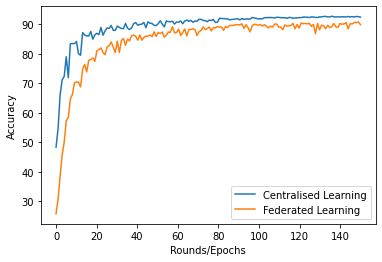

Distance in Accurancy:  2.5799999999999983


In [ ]:
import matplotlib.pyplot as plt

acc_rounds_saved = np.loadtxt(
    fname="/content/drive/MyDrive/FedLearningAcc.csv", delimiter=","
)

acc_epoch_saved = np.loadtxt(
    fname="/content/drive/MyDrive/CenLearningAcc.csv", delimiter=","
)

plt.plot(np.linspace(0, acc_epoch_saved.size, acc_epoch_saved.size), acc_epoch_saved, label='Centralised Learning')
plt.plot(np.linspace(0, acc_rounds_saved.size, acc_rounds_saved.size), acc_rounds_saved, label='Federated Learning')
plt.legend()
plt.xlabel("Rounds/Epochs")
plt.ylabel("Accuracy")
plt.show()
print('Distance in Accurancy: ', acc_epoch[acc_epoch.size-1]-acc_rounds[acc_rounds.size-1])